# Most of the code is taken from https://www.kaggle.com/code/joonasyoon/wgan-cp-with-celeba-and-lsun-dataset

In [1]:
import sys
sys.path.insert(0, '..') 

In [2]:
import argparse
import os
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as vdatasets
import torchvision.transforms as T
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_nb
from torchvision.models import inception_v3
from torch.utils.data import DataLoader, Subset
import warnings
warnings.filterwarnings("ignore")

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
from gan_package.gan import GAN
from gan_package.wGAN import Generator, Discriminator

# Initialize constants

In [5]:
# Number of workers for dataloader
workers = 16

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Nubmer of loop to train ciritic
n_critics = 5

# Learning rate for optimizers
lr = 0.0001

# Weight Clipping Limit
weight_cliping_limit = 0.01

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Animation keyframes for result
fig_keyframes = 20

# Device
device = torch.device('cuda' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Create dataset

In [6]:
dataset = vdatasets.ImageFolder(root='../lsun/bedroom',
                                transform=T.Compose([
                                    T.Resize(image_size),
                                    T.CenterCrop(image_size),
                                    T.ToTensor(),
                                    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Define WGAN network

In [7]:
generator = Generator()
generator.load_state_dict(torch.load('../models/wgan_generator.pth', map_location=torch.device('cpu')))
discriminator = Discriminator()
discriminator.load_state_dict(torch.load('../models/wgan_discriminator.pth', map_location=torch.device('cpu')))
inception_model = inception_v3(pretrained=True, transform_input=False, aux_logits=True)
gan = GAN(generator=generator, discriminator=discriminator, inception_model=inception_model)

In [8]:
netG = gan.generator
netD = gan.discriminator

optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

# Training loop

In [ ]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

total_steps = num_epochs * len(dataloader)
fig_save_interval = total_steps // fig_keyframes   # animation can contain max 36 images

pbar = tqdm_nb()
piter = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    pbar.reset(total=len(dataloader))
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1
        ################################################################
        # (1) Update D network: maximize D(x) + D(G(z)) 5 times
        ################################################################
        ## Train with all-real batch
        netD.zero_grad()
        
        real_img = data[0].to(device)
        b_size = real_img.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_img = netG(noise)
        
        errD = -torch.mean(netD(real_img)) + torch.mean(netD(fake_img)) # Wasserstein
        errD.backward()
        optimizerD.step()
        
        # Clip weights of discriminator
        for p in netD.parameters():
            p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)
        
        # Train Generator for every 5 steps
        if i % n_critics == 0:
            ################################################################
            # (2) Update G network: maximize D(G(z)
            ################################################################
            netG.zero_grad()

            gen_img = netG(noise)
            errG = -torch.mean(netD(gen_img))
            errG.backward()
            optimizerG.step()

            # Output training stats
            desc = '[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' \
                    % (epoch+1, num_epochs, i, len(dataloader), errD.item(), errG.item())
            pbar.set_description(desc)

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (piter - 1) % fig_save_interval == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
            print(desc)

pbar.refresh()

# Interpolation

In [9]:
def interpolate_points(p1, p2, n_steps=10):
    ratios = np.linspace(0, 1, num=n_steps)
    vs = []
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vs.append(v)
    return torch.stack(vs)

In [10]:
n1 = torch.randn(5, nz, 1, 1, device=device)
n2 = torch.randn(5, nz, 1, 1, device=device)
fake = []
for i in range(5):
    point = interpolate_points(n1[i], n2[i]).to(device)
    fake.append(netG(point))
fake = torch.vstack(fake).cpu()

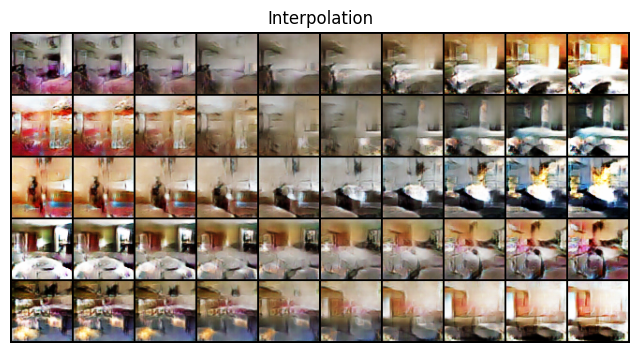

In [11]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Interpolation')
plt.imshow(np.transpose(vutils.make_grid(fake, nrow=10, padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()

# FID

In [ ]:
subset = Subset(dataset, np.random.choice(len(dataset), 1000, replace=False))
dataloader2 = DataLoader(subset, batch_size=1000, shuffle=True)
real_images = next(iter(dataloader2))[0]
fake_images = gan.generator(torch.randn(1000, 100, 1, 1))
real_images = F.resize(real_images, (75, 75))
fake_images = F.resize(fake_images, (75, 75))
fid_score = gan.calculate_fid_score(real_images, fake_images)

# Final results

In [ ]:
batch_size = 64
latent_dim = 100
z = torch.randn(batch_size, latent_dim, 1, 1)
image_array = netG(z).detach().numpy()

image_array = image_array.transpose(0, 2, 3, 1)

# Create a grid of subplots with a layout of 8x8
fig, axes = plt.subplots(8, 8, figsize=(10, 10))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over the batch and display each image
for i in range(batch_size):
    image = image_array[i]
    ax = axes[i]
    ax.imshow(image)
    ax.axis('off')

# Remove any extra subplots if the batch size is less than 64
for j in range(batch_size, 64):
    axes[j].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Show the grid of images
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.axis('off')
imgs = [[
    plt.imshow(np.transpose(img, (1,2,0)), animated=True),
    plt.text(0.5, 1.01, f'{step} iteration of {epoch} epoch', horizontalalignment='center', transform=ax.transAxes),
] for epoch, step, img in img_list]

ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1][-1],(1,2,0)))
plt.show()